# An Exploratory Approach for Multi-perspective Event Abstraction

In [1]:
import pandas as pd
from const import *
from clustering.retrieve import compute_similarities, retrieve_most_similar_events
from read import reader
from clustering import preprocessing
from clustering.clusterer import Clusterer
from config import Config
# the config object
config = Config("input/", "output/", "Mobis.csv", dict(), "MPPNTaskAbstractionMobIS_pd_cases_fv_fine_1", clust="k_means")

# Get event representations from disk
pd_events_fv, loaded = reader.load_mppn_representations(config)



pca_df, pca_rep = preprocessing.pca(pd_events_fv)
print("PCA done")

#preprocessing.viz(pca_df)



# Get similar events
#pd_events_fv = compute_similarities(pd_events_fv)
# Retrieve most similar events
#retrieve_most_similar_events(pd_events_fv, 5523, 6, top_n=5)

PCA done


In [2]:
clust = Clusterer(pd_events_fv, config)
clust.cluster(pca_rep, 27)
print("Clustering done")


Clustering done


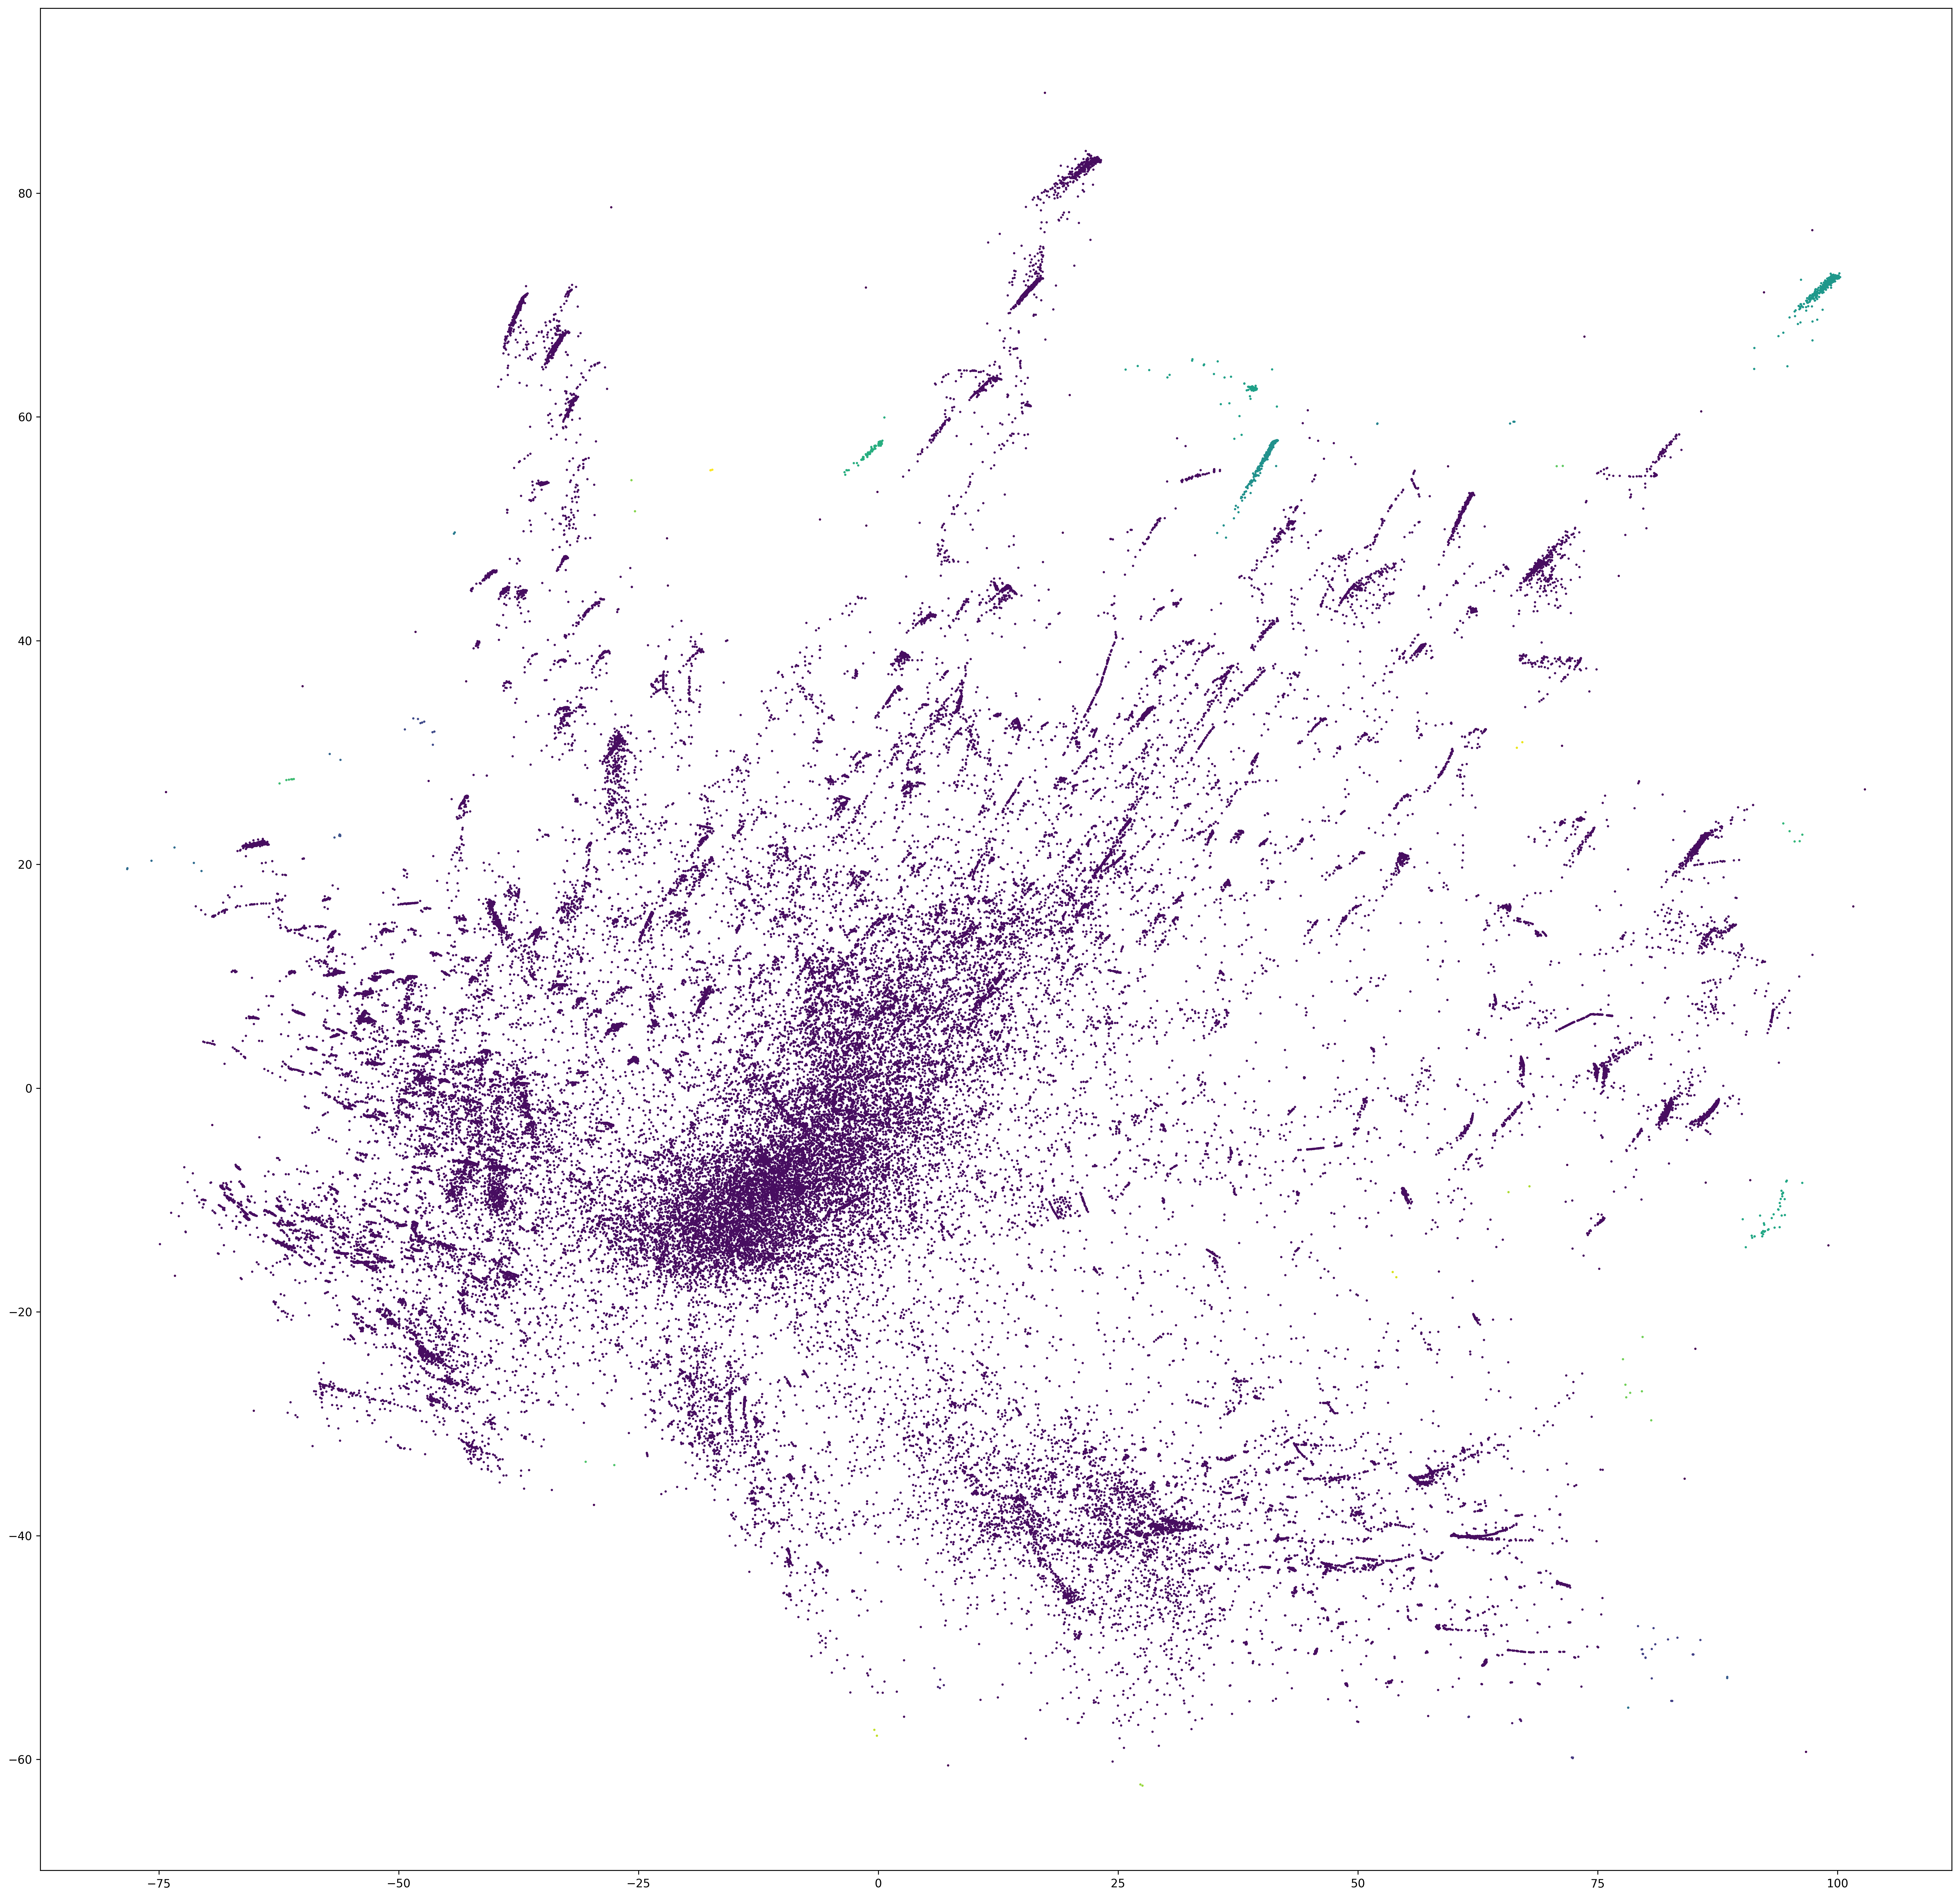

In [3]:
# add the cluster labels to the dataframe
pd_events_fv[CLUST_COL] = clust.pred_labels
pca_df[CLUST_COL] = clust.pred_labels
preprocessing.viz(pca_df, CLUST_COL, False)

In [4]:
pd_events_fv


IDX case:concept:name  \
0          0                 1   
65         1                 5   
130        2                 6   
131        2                 6   
195        3                 7   
...      ...               ...   
425946  6553              7267   
425947  6553              7267   
426010  6554              7268   
426011  6554              7268   
426012  6554              7268   

                                                    trace  \
0          case:concept:name  concept:name case:travel...   
65         case:concept:name  concept:name case:travel...   
130        case:concept:name        concept:name case:...   
131        case:concept:name        concept:name case:...   
195        case:concept:name                        co...   
...                                                   ...   
425946         case:concept:name                      ...   
425947         case:concept:name                      ...   
426010         case:concept:name                      ...   
426011         case:concept:name                      ...   
426012         case:concept:name                      ...   

                                                       fv  \
0       [4.1470294, 1.4067512, -4.3266125, 0.42475575,...   
65      [4.1470294, 1.4067512, -4.3266125, 0.42475575,...   
130     [5.0364475, -1.0454104, -2.2925222, -0.4669228...   
131     [-0.23424631, 0.6486099, -1.8590505, -0.101478...   
195     [-4.600467, -2.7162364, 7.385008, -1.5052035, ...   
...                                                   ...   
425946  [-0.94584674, 1.85064, -1.78104, 2.039534, 1.1...   
425947  [-9.127682, 3.452376, 5.5292363, 0.12529077, 0...   
426010  [-2.1489437, 10.0971, -6.4524198, -0.61791253,...   
426011  [-1.1794254, 2.0246515, -1.8443458, 2.0812948,...   
426012  [-9.2652235, 3.576524, 5.4925075, 0.11341269, ...   

        target_concept:name  \
0                       5.0   
65                      5.0   
130                     6.0   
131                     5.0   
195                     7.0   
...                     ...   
425946                 16.0   
425947                 17.0   
426010                 15.0   
426011                 16.0   
426012                 17.0   

                                  target_concept:name_enc  event_pos  clust  
0                                            pay expenses          0      0  
65                                           pay expenses          0      0  
130                                    calculate payments          0      0  
131                                          pay expenses          1      0  
195                    send original documents to archive          0      0  
...                                                   ...        ...    ...  
425946  check if travel request needs preliminary pric...          1      0  
425947                    decide on approval requirements          2      0  
426010                                file travel request          0      0  
426011  check if travel request needs preliminary pric...          1      0  
426012                    decide on approval requirements          2      0  

[83256 rows x 8 columns]

In [5]:
# get events of a cluster and compute properties
clust_to_props = {}
for clust, events in pd_events_fv.groupby(CLUST_COL):
    event_types = set()
    resources = set()
    roles = set()
    cat_atts = dict()
    num_atts = dict()
    preceded_by = set()
    followed_by = set()
    min_dur_per_case = 0
    max_dur_per_case = 0
    avg_dur_per_case = 0

    all_group_durs = set()
    for case, events_per_case in events.groupby(XES_CASE):
        #print(case)
        indices = events_per_case[EVENT_POS_IN_CASE].tolist()
        #print(indices)
        if len(events_per_case) < 1:
            continue
        case_full = events_per_case.iloc[0][TRACE_DF].iloc[indices]
        # else:
        #    case_full = events_per_case[TRACE_DF]
        #len(case_full)
        min_time = case_full[XES_TIME].min()
        max_time = case_full[XES_TIME].max()
        all_group_durs.add(max_time - min_time)
        # add event / activity types
        event_types.update(case_full[XES_NAME].tolist())
        # add resources
        resources.update(case_full[XES_RESOURCE].tolist())
        # add role
        roles.update(case_full[MOBIS_ROLE].tolist())
    for row in events.itertuples():
        try:
            preceded_by.add(row[COL_INDEX_TRACE].iloc[row[COL_INDEX_POS] - 1][XES_NAME])
        except:
            pass
        try:
            followed_by.add(row[COL_INDEX_TRACE].iloc[row[COL_INDEX_POS] + 1][XES_NAME])
        except:
            pass
    #preceded_by = preceded_by.difference(event_types)
    #followed_by = followed_by.difference(event_types)
    #print("resources", resources)
    #print("durations", all_group_durs)
    #print("roles", roles)
    print("activities", event_types)
    #print("predecessors", preceded_by)
    #print("followers", followed_by)


activities {'calculate payments', 'send original documents to archive', 'pay expenses'}
activities {'check booking proposal', 'send original documents to archive', 'check if travel request is still needed and up to date', 'request update of the booking proposal', 'book travel', 'check if booking is necessary', 'check if expense documents exist', 'send request for travel expense correction', 'check if travel request needs preliminary price inquiry', 'file travel request', 'transform price inquiry to travel request', 'upload travel expense documents', 'send request for correction', 'forward request to approver', 'prepare booking proposal', 'decide on request', 'decide on approval requirements', 'check if price inquiry is still needed and up to date', 'file travel expense report', 'correct travel expense report', 'send booking proposal to employee', 'confirm travel expense report', 'decide on travel expense approval'}
activities {'check if booking is necessary', 'check if travel request i

NameError: name 'np' is not defined